<img src = "https://raw.githubusercontent.com/touchaee/touchaee.github.io/master/images/Project-Capstone.png">
<h1 align = center>Where to open a new Thai restaurant in New York?</h1>

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Over the last 20 years, Thai restaurants have been one of the fastest-growing dining categories in New York City. Ever since the advent of places specializing in regional cuisines, often presenting recipes not seen here before, the Thai dining scene has been more exciting than ever before. So that now we have the fiery food of Isan in the northeast, the mellower food of Chiang Mai near the Burmese border, oodles of noodles from Sukhothai, the curries of central and southern Thailand, the urban cuisine of Bangkok, and the Malaysian-leaning food of the peninsula. Our newest arrival is the food of the capital’s Chinatown.

But the pandemic has been tough on Thai restaurants, a one-third have closed, mostly as a result of the pandemic. The good news is that new places have arisen to replace them; in fact, Thai has been most prominent in the category of new restaurants, as will be shown in what follows, along with lots of highly recommended old favorites.

This project aims to find a location for the opening of a Thai restaurant in NY, Specifically, this report will be targeted to stakeholders interested in opening any restaurant place like **Thai Restaurant** in **New York City**.

The first task would be to **find the areas lack Thai Restaurants** by analyzing restaurant data from FourSquare API and **shortlisting an area**, where Thai restaurant is not amongst the most common venues.

We will make use of our data science tools to analyze data and focus on the areas and explore its areas and the 10 most common venues in each area so that the best areas where Thai restaurant is not amongst the most common venue can be selected.

## Data <a name="data"></a>

Based on the definition of our problem, the factors that will influence our decision are:
* finding the areas lack Thai Restaurants
* finding the most common venues
* Choosing the right neighborhood within the borough

We will be using the geographical coordinates of NY to plot neighborhoods in a borough that is lack of Thai Restaurant and in the city's vicinity, and finally, cluster our neighborhoods and present our findings.

Following data sources will be needed to extract/generate the required information:

- [**Part 1**: Using a real-world data set from Kaggle containing the Vancouver Crimes from 2003 to 2019](#part1):  A dataset consisting of the crime statistics of each Neighborhood in Vancouver along with the type of crime, recorded year, month, and hour.

- [**Part 2**: Gathering additional information on the list of officially categorized boroughs in Vancouver from Wikipedia.](#part2): Borough information will be used to map the existing data where each neighborhood can be assigned with the right borough.

- [**Part 3**: Creating a new consolidated dataset of the Neighborhoods, along with their boroughs, crime data, and the respective Neighbourhood's co-ordinates.](#part3): This data will be fetched using OpenCage Geocoder to find the safest borough and explore the neighborhood by plotting it on maps using Folium and perform exploratory data analysis.

- [**Part 4**: Creating a new consolidated dataset of the Neighborhoods, boroughs, and the most common venues and the respective Neighbourhood along with co-ordinates.](#part4): This data will be fetched using Four Square API to explore the neighborhood venues and to apply a machine learning algorithm to cluster the neighborhoods and present the findings by plotting it on maps using Folium.

### Importing all the necessary Libraries

In [35]:
import numpy as np
import pandas as pd

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

#mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

#Importing itertools for visualize
from itertools import cycle, islice

print('Libraries imported')

Matplotlib version:  3.1.0
Libraries imported


### **Part 1:** Using a IBM dataset containing the New York Borough, Neighborhood and geometry coordinates<a name="part1"></a>


####  New York Dataset

Properties of the New York dataset

*   Borough - Recorded borough
*   Neighborhood - Recorded neighborhood
*   Latitude - Recorded latitude
*   Longitude - Recorded longitude


Data set URL: https://cocl.us/new_york_dataset

In [2]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        # get Borough and Neighborhood
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        # get Latitude and Longitude
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [3]:
df = get_new_york_data()

### Total Neighborhood in different Borough

In [48]:
df_count_neigh = df.groupby('Borough').count()['Neighborhood'].sort_values(ascending = False).to_frame()

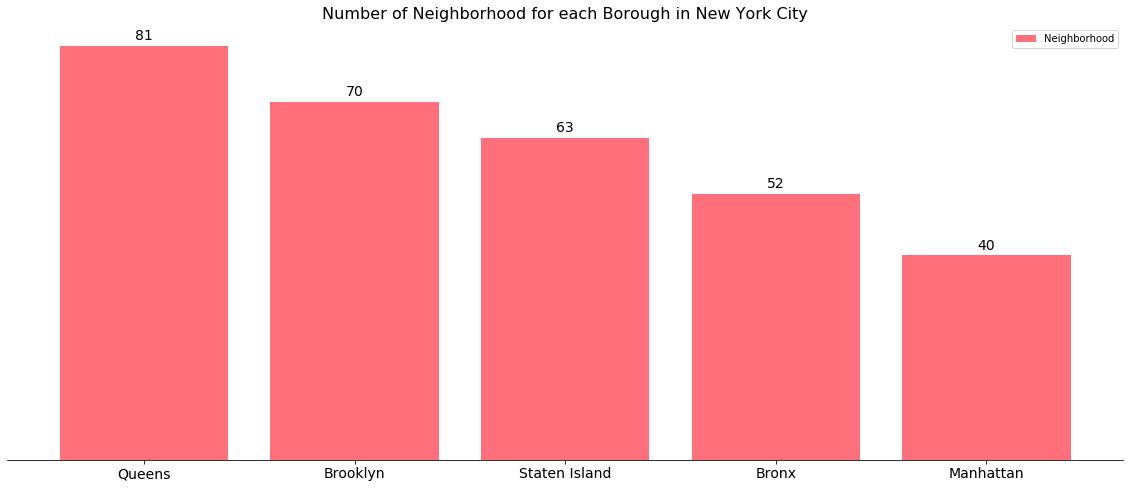

In [50]:
#set ax parameters
figsize = (20, 8)
width = 0.8
title = "Number of Neighborhood for each Borough in New York City"

#Create ax
ax = df_count_neigh.plot(kind = 'bar', figsize = figsize, width = width, color = '#FF707B', rot = 0)

#Text Decoration
ax.set_title(title, fontdict = {'fontsize': 16})
ax.set_xticklabels(df_count_neigh.index, fontdict = {'fontsize': 14})
ax.set_xlabel("")

#Borderless
ax.set_yticklabels("")
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:                 
    ax.annotate(
        "{}".format(p.get_height()),
        (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center',
        va='center', 
        xytext=(0, 10),
        textcoords='offset points', 
        fontsize = 14
    )
    

We see that Queens has highest number of neighborhoods

### **Part 2:** Gathering additional information about the Thai Restaurant for each neighborhood from FoursquareAPI<a name="part2"></a>